Note:
You need GPU. On the top right(RAM Disk bar), choose change runtime type > GPU.



# About the Notebook
This notebook is for loading the finetuned model for testing and evaluation purpose

# Install Required Packages
*Use "pip install" to install the package*

In [ ]:
! pip install transformers==4.36.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [ ]:
! pip install torch==2.1.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.3 MB/s eta 0:00:00
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

# Load Python Libraries


In [ ]:
import gc
import os
import re
import time
import random
import datetime

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup


nltk.download('stopwords')
torch.cuda.empty_cache()
gc.collect()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# To make the run deterministic
SEED = 272419
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# tf.random.set_seed(SEED)

# Download  Dataset

In [ ]:
# download the data from the github data source
! git clone https://github.com/MilaNLProc/translation_bias.git

Cloning into 'translation_bias'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 27 (delta 0), reused 27 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 3.95 MiB | 27.54 MiB/s, done.


In [ ]:
# load .xlsx using pandas read_excel()
df_test = pd.read_excel("/content/translation_bias/data/en_us/en_us_TEST.xlsx")

# view top 2 rows from the data
df_test.head(2)

,Unnamed: 0,text,age,age_cat,gender,label
0,0,Used this site many times. I always start mys...,50,25-54,F,test
1,1,Great prices!! and the fact that they will mat...,32,25-54,M,test


# Prepare Test data

In [ ]:
# renaming columns
df_test.rename(columns={'label': 'data_for','age_cat':'ageRange'}, inplace=True)

# drop unamed column
df_test.drop(["Unnamed: 0"], axis=1, inplace=True)

# Convert the string labels to Categorical label
gender_label_map = {
    "F": 0,
    "M": 1
}

df_test["label"] = df_test['gender'].map(gender_label_map)
df_test.head()

,text,age,ageRange,gender,data_for,label
0,Used this site many times. I always start mys...,50,25-54,F,test,0
1,Great prices!! and the fact that they will mat...,32,25-54,M,test,1
2,Used Ebay for sales and purchases for the past...,48,25-54,M,test,1
3,Used Paypal for my buying and selling for the ...,48,25-54,M,test,1
4,I ordered on April 30 and finally received my ...,48,25-54,M,test,1


In [ ]:
def get_text_and_label(df):
    X = df["text"].values
    y = df["label"].values
    return X, y

# Get performance on test set
X_test, y_test = get_text_and_label(df_test)

print(np.unique(y_test))
print(X_test.shape)
print(y_test.shape)

[0 1]
(403,)
(403,)


# Download finetuned model
Model was finetuned for English Dataset using 'bert-base-uncased' model for Gender Classification:M/F with epochs = 4.

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1YOMOjYPPGNSpcXvbDhCy_YH8RhZYRDPA?usp=sharing

Retrieving folder contents
Processing file 1T0USb69IDHW-w9wap_4RZOE4biNwmnmr config.json
Processing file 1-9NPw_yNHoaCETD3TY74BHSEngZh9sAt model.safetensors
Processing file 1-HWW0Cq1V1X8C5dO-2Y-c54RWImWNI2w special_tokens_map.json
Processing file 1-IcfQSnNFmJt2nWMPIut7jePOipB-6Mg tokenizer_config.json
Processing file 1-ByBnoToAYaAxHQ3aRfB_uQtcUyPW9-3 tokenizer.json
Processing file 1-HJ1c-c8wuoYaHbLfkglQ80s4hYeOPn_ vocab.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T0USb69IDHW-w9wap_4RZOE4biNwmnmr
To: /content/bert-base-uncased-genderclf/config.json
100% 759/759 [00:00<00:00, 3.60MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-9NPw_yNHoaCETD3TY74BHSEngZh9sAt
From (redirected): https://drive.google.com/uc?id=1-9NPw_yNHoaCETD3TY74BHSEngZh9sAt&confirm=t&uuid=faf630a3-c0e7-4b24-b79b-cba84a9daf47
To: /content/bert-base-uncased-genderclf/model.safetensors

# Load the downloaded Finetuned Model

In [ ]:
model_folder_path = "/content/bert-base-uncased-genderclf"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_folder_path, output_hidden_states=True)

# Load model for sequence classification, the pretrained model with a single linear classification layer on top.
model = AutoModelForSequenceClassification.from_pretrained(model_folder_path, num_labels=2,ignore_mismatched_sizes=True)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def tokenize(texts, tokenizer, max_len):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every text...
    for idx, text in enumerate(texts):
        encoded_dict = tokenizer.encode_plus(
            text,                      # Sentence to encode.
            add_special_tokens = True,
            padding = "max_length",
            truncation = True,
            max_length = max_len,
            return_attention_mask = True,
            return_tensors = 'pt')

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert to tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Prepare Test data for Prediction

In [ ]:
# Maximal length of input sequence
max_len = 512 #BERT model takes only 512 length
batch_size = 8

input_ids, attention_masks = tokenize(texts=X_test, tokenizer=tokenizer, max_len=max_len)
y_test = torch.tensor(y_test)

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, y_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        #token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 403 test sentences...
    DONE.


# Test Accuracy

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Print results:
accuracy = accuracy_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions, average="macro")

print("Accuracy:",  round(accuracy, 10))
print()

print("Macro-F1:", round(f1, 10))
print()


Accuracy: 0.6476426799

Macro-F1: 0.6476405103



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       202
           1       0.65      0.65      0.65       201

    accuracy                           0.65       403
   macro avg       0.65      0.65      0.65       403
weighted avg       0.65      0.65      0.65       403



# Confusion Matrix Plot

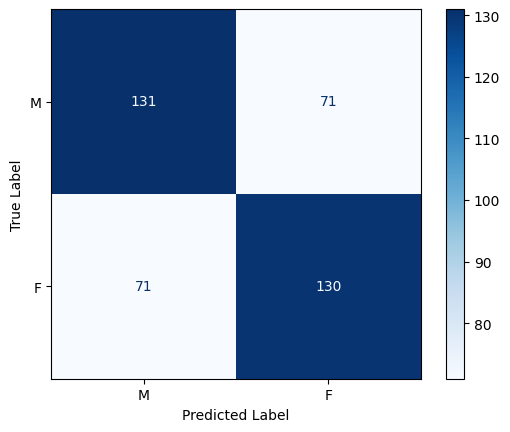

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def find_keys(value):
    return [key for key, x in gender_label_map.items() if x == value][0]

flat_true_labels_mapped = [find_keys(i) for i in flat_true_labels]
flat_predictions_mapped = [find_keys(i) for i in flat_predictions]
target_names = list(set(flat_true_labels_mapped))
conf_matrix = confusion_matrix(y_true=flat_true_labels_mapped, y_pred=flat_predictions_mapped)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
disp.ax_.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

# Save the prediction

In [ ]:
df_pred = pd.DataFrame({"label": flat_true_labels,
                        "text": X_test,
                        "predicted_label": flat_predictions})

df_pred.to_csv("bert-base-uncased-genderclf-prediction.csv",
               encoding="utf-8", index=False)

df_pred.head()

,label,text,predicted_label
0,0,Used this site many times. I always start mys...,1
1,1,Great prices!! and the fact that they will mat...,1
2,1,Used Ebay for sales and purchases for the past...,1
3,1,Used Paypal for my buying and selling for the ...,1
4,1,I ordered on April 30 and finally received my ...,0
